In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv
import multivelo as mv

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = True
matplotlib.rcParams['ytick.labelleft'] = False
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.left'] = False

In [3]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [4]:
c_ = np.empty((100*5, 1000))
u_ = np.empty((100*5, 1000))
s_ = np.empty((100*5, 1000))
alpha_c_ = np.empty((100*5))
alpha_ = np.empty(100*5)
beta_ = np.empty(100*5)
gamma_ = np.empty(100*5)


In [5]:
for i, (direction, model) in enumerate(zip(['complete', 'complete',
                                            'on',
                                            'off', 'off'],
                                           [1, 2, 1, 1, 2])):
    c_[i*100:(i+1)*100], u_[i*100:(i+1)*100], s_[i*100:(i+1)*100],\
        alpha_c_[i*100:(i+1)*100], alpha_[i*100:(i+1)*100], beta_[i*100:(i+1)*100], gamma_[i*100:(i+1)*100] =\
            mf.simulate(1000, 100, direction=direction, model=model)

In [ ]:
for i in rang

In [6]:
c_ +=np.random.rand(500, 1000)*0.001
u_ +=np.random.rand(500, 1000)*0.001
s_ +=np.random.rand(500, 1000)*0.001

In [7]:
c_ = np.clip(c_, 0, 1)
u_ = np.clip(u_, 0, None)
s_ = np.clip(s_, 0, None)

In [8]:
var = pd.DataFrame({'Alpha': alpha_,
              'Beta': beta_,
              'Gamma': gamma_,
              'Alpha_c': alpha_c_,
})

In [9]:
obs = pd.DataFrame({'time': np.linspace(0, 20, 1000)})

In [10]:
adata_rna = anndata.AnnData(obs=obs, var=var, X=s_.T)
adata_atac = anndata.AnnData(obs=obs, var=var, X=c_.T)
adata_rna.layers['Mu'] = u_.T
adata_rna.layers['Ms'] = s_.T
adata_atac.layers['Mc'] = c_.T

In [11]:
adata_rna.layers['unspliced'] = adata_rna.layers['Mu']
adata_rna.layers['spliced'] = adata_rna.layers['Ms']

In [12]:
adata_rna.obs_names = [f'cell_{i}' for i in range(1000)]
adata_rna.var_names = [f'gene_{i}' for i in range(500)]

In [13]:
import scanpy as sc

In [14]:
sc.tl.pca(adata_rna)

In [15]:
sc.pp.neighbors(adata_rna)

In [16]:
sc.tl.umap(adata_rna)

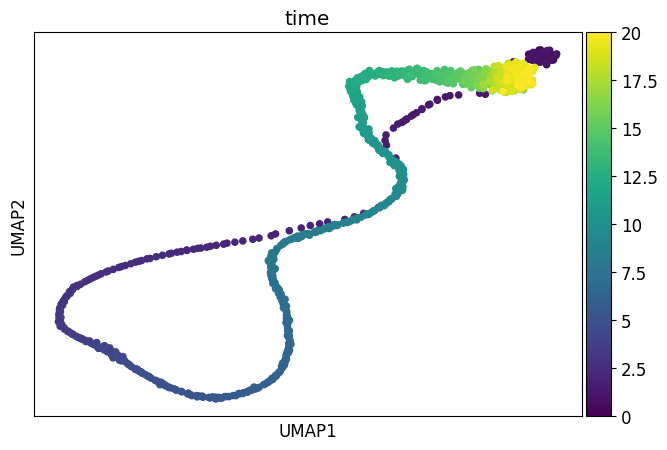

In [17]:
sc.pl.scatter(adata_rna, basis='umap',
              color='time')

In [12]:
adata_rna.write_h5ad('../temps/250316_adata_rna.h5ad')
adata_atac.write_h5ad('../temps/250316_adata_atac.h5ad')

In [20]:
adata_rna = anndata.read_h5ad('../temps/250316_adata_rna.h5ad')
adata_atac = anndata.read_h5ad('../temps/250316_adata_atac.h5ad')

In [ ]:
adata_rna.obs_names = [f'cell_{i}' for i in range(1000)]
adata_rna.var_names = [f'gene_{i}' for i in range(324)]

In [72]:
adata_result = mv.recover_dynamics_chrom(adata_rna,
                                         adata_atac,
                                         max_iter=5,
                                         n_jobs=4,
                                         init_mode="invert",
                                         parallel=True,
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         n_anchors=500,
                                         
                                        )

Missing connectivities in ATAC adata object, using RNA connectivities instead

324 genes will be fitted

running 4 jobs in parallel



  0%|          | 0/324 [00:00<?, ?it/s]

3 - predicted partial trajectory: True

3 - predicted trajectory direction:on

3 - predicted model: 1

0 - predicted partial trajectory: True

0 - predicted trajectory direction:on

0 - predicted model: 1

2 - predicted partial trajectory: True

2 - predicted trajectory direction:on

2 - predicted model: 1

1 - predicted partial trajectory: True

1 - predicted trajectory direction:on

1 - predicted model: 1

3 - initial params:
switch time array = [1. 2. 4.],
rates = [1.02223608 3.10328861 1.         0.69777439],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6693645373169667

3 - initial loss: 0.7168702936714346

0 - initial params:
switch time array = [1. 2. 4.],
rates = [1.91740297 4.7596047  1.         0.61050342],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7090937396908188

0 - initial loss: 0.7378445191304188

1 - initial params:
switch time array = [1. 2. 4.],
rates = [1.44270694 4.2586275  1.         0.61697741],
cc scale = 1.0,
c rescale factor 

In [88]:
adata_result.layers['unspliced'] = adata_rna.layers['unspliced']
adata_result.layers['spliced'] = adata_rna.layers['spliced']

In [89]:
scv.tl.velocity_graph(adata_result)
scv.tl.latent_time(adata_result)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/255 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


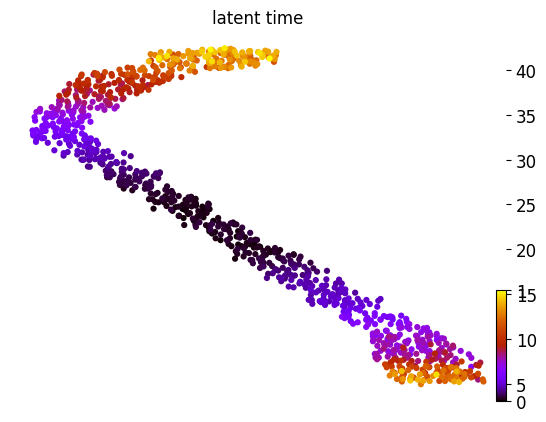

In [92]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)


In [94]:
adata_result.write_h5ad('250316_simul_multivelo.h5ad')

In [25]:
moflow = mf.MOFlow(adata_rna,
                adata_atac,
                gene_list=None,
                cluster_key='celltype_new',
                folder_name='MoSync_velocity_simulation',
                max_epoches=200)

Using /home/local/arihong_970924/workspace/proj_jp/2024/MoFlow/notebooks/MoSync_velocity_simulation as the output path.
time is not found! Set to 0
cluster is not found! Set to 0


In [26]:
moflow.velocity(adata_rna,
                file_path='MoSync_velocity_simulation',
                file_name='250316_adata_out.h5ad'
)

g ('branch', 'on', 0.9208339)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10

Arranging genes for parallel job.
324  genes were arranged to  2  portions.


gene_0 ('branch', 'on', 0.9208339)
gene_3 ('branch', 'on', 0.42316303)
gene_5 ('branch', 'on', 0.29169643)
gene_7 ('branch', 'on', 0.41699025)
gene_4 ('branch', 'on', 0.15779385)
gene_10 ('branch', 'on', 0.015979597)
gene_1 ('branch', 'on', 0.14770181)
gene_2 ('branch', 'on', 1.6812851)
gene_8 ('branch', 'on', 0.27532497)
gene_6 ('branch', 'on', 0.40808168)
gene_11 ('branch', 'on', 0.07259238)
gene_9 ('branch', 'on', 0.3393885)
gene_12 ('branch', 'on', 0.10000115)
gene_15 ('branch', 'on', 0.39167327)
gene_18 ('branch', 'on', 0.055634633)
gene_14 ('branch', 'on', 0.31407326)
gene_13 ('branch', 'on', 0.1856634)
gene_16 ('branch', 'on', 0.47843182)
gene_17 ('branch', 'on', 0.18942602)
gene_24 ('branch', 'on', 0.01095554)
gene_19 ('branch', 'on', 0.14563979)
gene_25 ('branch', 'on', 0.039746847)
gene_20 ('branch', 'on', 0.4484471)
gene_22 ('branch', 'on', 0.1047081)
gene_23 ('branch', 'complete', 0.94625556)
gene_26 ('branch', 'on', 0.28033867)
gene_30 ('branch', 'on', 0.120121725)
gene_31

/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/par

gene_105 ('branch', 'on', 0.13203302)
gene_106 ('branch', 'on', 0.19967048)
gene_108 ('branch', 'on', 1.1804367)
gene_107 ('branch', 'on', 0.9060947)
gene_113 ('branch', 'on', 0.04727513)
gene_112 ('branch', 'complete', 0.5134356)
gene_117 ('branch', 'on', 0.1142886)
gene_114 ('branch', 'on', 0.6336679)
gene_111 ('branch', 'complete', 0.52294064)
gene_116 ('branch', 'on', 0.693311)
gene_118 ('branch', 'on', 0.08648701)
gene_115 ('branch', 'on', 0.0)
gene_120 ('branch', 'on', 0.2749232)
gene_119 ('branch', 'on', 0.71403843)
gene_123 ('branch', 'on', 0.23409876)
gene_122 ('branch', 'on', 0.35780364)
gene_121 ('branch', 'on', 0.1557661)
gene_124 ('branch', 'on', 0.0770269)
gene_127 ('branch', 'on', 0.09110978)
gene_126 ('branch', 'on', 0.11866328)
gene_109 ('branch', 'complete', 0.74730504)
gene_110 ('branch', 'on', 0.08988806)
gene_125 ('branch', 'on', 0.4234227)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
TPU available: False, using: 0 TPU cores
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/li

gene_128 ('branch', 'on', 0.3899907)
gene_129 ('branch', 'on', 0.23852223)
gene_130 ('branch', 'on', 0.1723782)
gene_131 ('branch', 'on', 0.0)
gene_132 ('branch', 'on', 0.2726065)
gene_133 ('branch', 'on', 0.43617782)
gene_134 ('branch', 'complete', 0.42340308)
gene_135 ('branch', 'on', 0.0)
gene_137 ('branch', 'on', 0.097358644)
gene_136 ('branch', 'on', 0.0)
gene_140 ('branch', 'complete', 0.8841138)
gene_139 ('branch', 'on', 0.065801)
gene_141 ('branch', 'on', 0.28882116)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performanc

gene_142 ('branch', 'on', 0.28835624)
gene_143 ('branch', 'on', 0.51958656)
gene_138 ('branch', 'on', 2.1325266)
gene_144 ('branch', 'on', 0.101042025)
gene_145 ('branch', 'on', 0.4245977)
gene_146 ('branch', 'on', 0.46022615)
gene_147 ('branch', 'on', 0.75698745)
gene_148 ('branch', 'complete', 0.29178596)
gene_149 ('branch', 'on', 0.0)
gene_150 ('branch', 'on', 0.07080908)
gene_151 ('branch', 'on', 0.017889567)
gene_152 ('branch', 'on', 0.44817764)
gene_154 ('branch', 'on', 0.294869)
gene_153 ('branch', 'on', 0.0)
gene_155 ('branch', 'on', 0.5867859)
gene_156 ('branch', 'on', 0.74288625)
gene_158 ('branch', 'on', 0.28389925)
gene_157 ('branch', 'on', 0.2483737)
gene_159 ('branch', 'on', 0.0)
gene_160 ('branch', 'on', 0.33568165)
gene_162 ('branch', 'on', 0.58267224)
gene_161 ('branch', 'on', 0.07423278)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does n

gene_164 ('branch', 'on', 0.0)
gene_163 ('branch', 'on', 2.1609511)
gene_166 ('branch', 'on', 0.20771185)
gene_165 ('branch', 'on', 0.6381268)
gene_167 ('branch', 'on', 0.090415455)
gene_169 ('branch', 'on', 0.0042259097)
gene_168 ('branch', 'complete', 0.65462947)
gene_171 ('branch', 'on', 0.15047796)
gene_170 ('branch', 'on', 0.063328944)
gene_175 ('branch', 'on', 0.27541894)
gene_172 ('branch', 'complete', 0.89430094)
gene_174 ('branch', 'on', 0.70065135)
gene_173 ('branch', 'on', 0.09882522)
gene_176 ('branch', 'on', 0.3553833)
gene_177 ('branch', 'on', 0.10599849)
gene_178 ('branch', 'on', 0.17361102)
gene_179 ('branch', 'on', 0.0)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.

gene_181 ('branch', 'on', 0.070935726)
gene_180 ('branch', 'on', 0.47978204)
gene_183 ('branch', 'on', 0.0)
gene_182 ('branch', 'on', 0.6240564)
gene_184 ('branch', 'on', 0.44734347)
gene_186 ('branch', 'on', 0.04181626)
gene_185 ('branch', 'on', 0.24255633)
gene_187 ('branch', 'on', 0.1233204)
gene_189 ('branch', 'on', 0.0)
gene_188 ('branch', 'on', 0.05162181)
gene_190 ('branch', 'on', 1.5299898)
gene_193 ('branch', 'complete', 2.3517542)
gene_192 ('branch', 'on', 0.34126353)
gene_191 ('branch', 'on', 0.015028405)
gene_194 ('branch', 'on', 0.54027104)
gene_197 ('branch', 'on', 0.28667817)
gene_196 ('branch', 'on', 0.0)
gene_195 ('branch', 'on', 0.41546127)
gene_198 ('branch', 'complete', 0.84270346)
gene_199 ('branch', 'on', 0.2270557)
gene_200 ('branch', 'on', 0.151389)
gene_201 ('branch', 'complete', 0.8023893)
gene_202 ('branch', 'on', 0.0)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10

gene_203 ('branch', 'on', 0.68149877)
gene_204 ('branch', 'on', 0.4370217)
gene_205 ('branch', 'on', 0.09664943)
gene_206 ('branch', 'on', 0.21682218)
gene_207 ('branch', 'on', 0.00038431826)
gene_208 ('branch', 'on', 0.028312009)
gene_209 ('branch', 'on', 0.06760005)
gene_210 ('branch', 'on', 0.3624488)
gene_211 ('branch', 'on', 0.05610908)
gene_212 ('branch', 'on', 1.0171032)
gene_213 ('branch', 'on', 0.060523126)
gene_214 ('branch', 'on', 0.3269977)
gene_215 ('branch', 'on', 0.43574935)
gene_216 ('branch', 'on', 0.1974115)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance

gene_217 ('branch', 'on', 0.9524018)
gene_218 ('branch', 'on', 0.45993146)
gene_219 ('circle', 'on', 0.59709394)
gene_220 ('branch', 'on', 0.23140842)
gene_221 ('branch', 'on', 0.30407542)
gene_222 ('branch', 'on', 0.068303935)
gene_223 ('branch', 'on', 1.5389001)
gene_224 ('branch', 'on', 0.4375862)
gene_225 ('branch', 'on', 0.0)
gene_226 ('branch', 'on', 0.58671075)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/en

gene_227 ('branch', 'complete', 0.7432858)
gene_228 ('branch', 'on', 0.0)
gene_229 ('branch', 'on', 0.060795523)
gene_230 ('branch', 'on', 0.36198083)
gene_231 ('branch', 'on', 0.102878675)
gene_232 ('branch', 'on', 0.16392972)
gene_233 ('branch', 'on', 0.0)
gene_234 ('branch', 'on', 0.07309264)
gene_235 ('branch', 'on', 0.32921368)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/

gene_236 ('branch', 'on', 0.21380721)
gene_238 ('branch', 'on', 0.0)
gene_237 ('branch', 'on', 0.43175846)
gene_239 ('branch', 'on', 0.7370068)
gene_241 ('branch', 'on', 0.6126088)
gene_242 ('branch', 'on', 0.0667518)
gene_240 ('branch', 'complete', 0.58528274)
gene_243 ('branch', 'on', 0.029737758)
gene_244 ('branch', 'on', 0.0)
gene_245 ('branch', 'on', 0.033160277)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/u

gene_246 ('branch', 'on', 0.07089591)
gene_247 ('branch', 'on', 0.07060997)
gene_248 ('branch', 'on', 0.0)
gene_249 ('branch', 'on', 0.0)
gene_250 ('branch', 'on', 0.099801295)
gene_251 ('branch', 'on', 0.055444084)
gene_252 ('branch', 'on', 0.0)
gene_254 ('branch', 'on', 0.0)
gene_253 ('branch', 'on', 0.011189798)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/arihong_970924/anaconda3/envs/mosync/li

gene_255 ('branch', 'on', 0.14685105)
gene_257 ('branch', 'on', 0.0508309)
gene_256 ('branch', 'on', 0.0018152026)
gene_258 ('branch', 'on', 0.08629199)
gene_259 ('branch', 'on', 0.0)
gene_261 ('branch', 'on', 0.0)
gene_262 ('branch', 'on', 0.06581919)
gene_263 ('branch', 'on', 0.06443448)
gene_260 ('branch', 'on', 0.0523291)
gene_264 ('branch', 'on', 0.014242764)
gene_265gene_266 ('branch', 'on', 0.0) 
('branch', 'on', 0.0)
gene_267 ('branch', 'on', 0.07505056)
gene_268 ('branch', 'on', 0.06210751)
gene_269 ('branch', 'on', 0.0)
gene_272 ('branch', 'on', 0.06825526)
gene_270 ('branch', 'on', 0.011437315)
gene_271 ('branch', 'on', 0.0)
gene_273 ('branch', 'on', 0.0)
gene_274 ('branch', 'on', 0.12991703)
gene_275 ('branch', 'on', 0.133037)
gene_276 ('branch', 'on', 0.0110466685)
gene_277 ('branch', 'on', 0.058490697)
gene_278 ('branch', 'on', 0.0)
gene_279 ('branch', 'on', 0.0062149623)
gene_280 ('branch', 'on', 0.037831355)
gene_281 ('branch', 'on', 0.0)
gene_283 ('branch', 'on', 0.0)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/par

gene_307 ('branch', 'on', 0.0)
gene_306 ('branch', 'on', 0.0)
gene_308 ('branch', 'on', 0.005063635)
gene_309 ('branch', 'on', 0.0)
gene_310 ('branch', 'on', 0.0050814766)
gene_311 ('branch', 'on', 0.0)
gene_312 ('branch', 'on', 0.01923256)
gene_313 ('branch', 'on', 0.06991203)
gene_314 ('branch', 'on', 0.0)
gene_315 ('branch', 'on', 0.05267506)
gene_316 ('branch', 'on', 0.0)
gene_317 ('branch', 'on', 0.0)
gene_318 ('branch', 'on', 0.0133287795)
gene_321 ('branch', 'on', 0.0)
gene_320 ('branch', 'on', 0.10315975)
gene_319 ('branch', 'on', 0.0011970367)
gene_323 ('branch', 'on', 0.0)
gene_322 ('branch', 'on', 0.0)


/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/arihong_970924/anaconda3/envs/mosync/lib/python3.10/site-packag

write data
Result is perfectly saved at MoSync_velocity_simulation/250316_adata_out.h5ad


In [28]:
adata_out = anndata.read_h5ad(
    'MoSync_velocity_simulation/250316_adata_out.h5ad')

computing velocity graph (using 1/255 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velo_s_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_umap', embedded velocity vectors (adata.obsm)


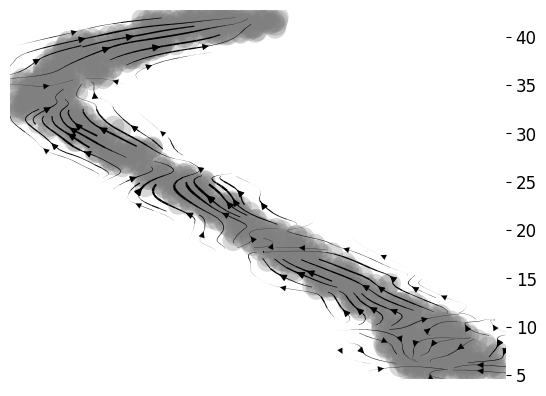

In [30]:
scv.tl.velocity_graph(adata_out,
                        vkey='velo_s', xkey='s'
                        )
scv.pl.velocity_embedding_stream(adata_out,
                                 vkey='velo_s',
)

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


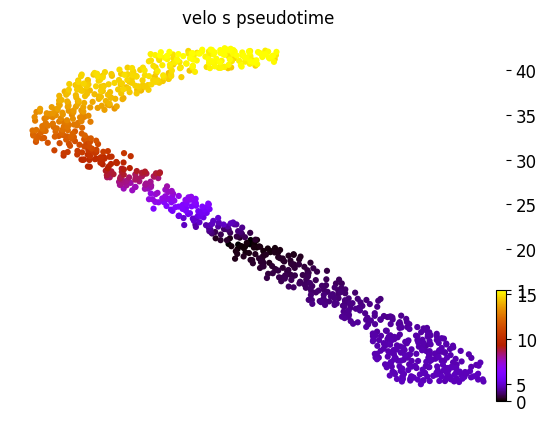

In [31]:
scv.tl.velocity_pseudotime(adata_out, vkey='velo_s'
)
scv.pl.scatter(adata_out, color='velo_s_pseudotime',
               cmap='gnuplot', size=80)